In [2]:
#! python -m pip install wget
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

from astropy import coordinates as coord
from astropy import units as u

import wget

from astropy.table import Table
from astroquery.sdss import SDSS

%matplotlib inline

### Histogram of Host Galaxy search radius
Based on data retrieved from the Hyperleda galaxy databse in a seperate notebook ([Hyperleda_load](./Hyperleda_load.ipynb)), we want to show the diameter used for the cone search (the python script, galsearch.py) - currently using 3x the logd25 parameter for the cone search radius.

First, load the filtered galaxy list from the above notebook into a DataFrame.

In [3]:
# first load example data (e.g. test_100.csv)
with open('data/HLGalaxies_filtered.csv') as f:
    HLdata = pd.read_csv(f, header=0)

HLdata.columns
HLdata_unmod = HLdata

In [4]:
print(HLdata.iloc[6])

Name                                                        NGC4472
RA                                                       187.444536
DEC                                                        7.999724
l                                                        286.921492
b                                                         70.195259
extinct                                                       0.096
eff_B-V                                                       0.975
t                                                              -4.8
type                                                              E
v                                                             978.7
e_v                                                             8.3
dist_Hf                                                   13.981429
bt                                                            9.346
e_bt                                                          0.121
Bmagt                                           

In [5]:
HLdata['appDiam_kpc'].describe()

count    3656.000000
mean       32.158217
std        10.316905
min         2.892851
25%        25.242098
50%        30.579171
75%        37.477958
max       104.646683
Name: appDiam_kpc, dtype: float64

In [6]:
appDiam_kpc = HLdata['appDiam_kpc']*3

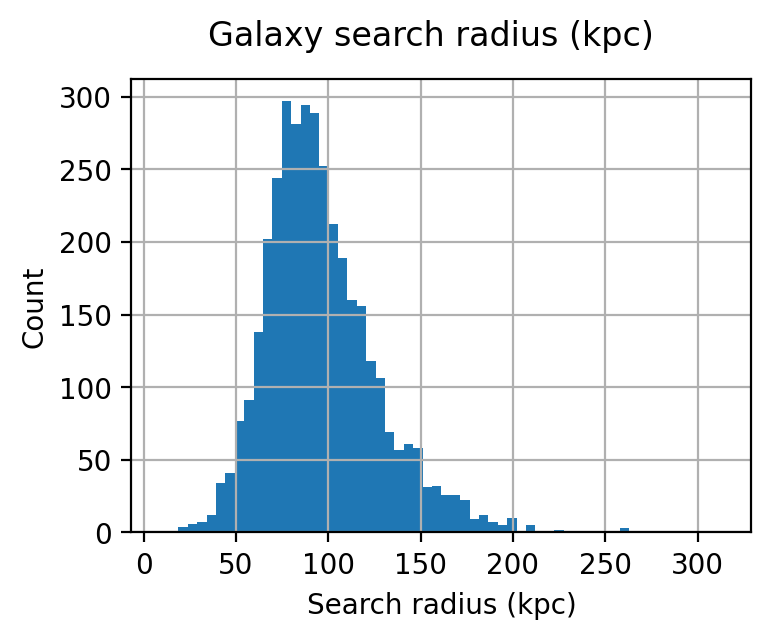

In [7]:
fig, ax = plt.subplots(figsize=(4,3), dpi=200)

appDiam_kpc.hist(bins=60, ax=ax)
ax.set_xlabel('Search radius (kpc)', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
fig.suptitle('Galaxy search radius (kpc)', fontsize=12)

fig.savefig('figures/Gal_search_rad(3xDiam).png', bbox_inches='tight')


### Retrieval of SDSS data for Re calculation
Now want to make size of galaxy host more robust, so want to download parameters from SDSS DB - specifically:

- petroMag_g/r
- petroR50_g/r
- petroR90_g/r
- deVRad_g/r
- expRad_g/r

The first gives reference SDSS magnitudes ('r' especially), while the second and third will be used to calculate Re from Graham et al. (2005), eq.7 with a comparison with the final two parameters which are  
> de Vaucouleurs fit scale radius, here defined to be the same as the half-light radius, also called the effective radius.

and
> exponential fit scale radius, here defined to be the same as the half-light radius, also called the effective radius.

Equation for calculation of Re is 

$R_e \approx \frac{R_{50}}{1 - P_3 (R_{90} / R_{50})^{P_4}} $

where P3 and P4 equal $8.0\times10^{-6}$ and $8.47$, respectively.

In [8]:
def get_SDSS_gal_data(index, ra, dec, cone_arcsec):
    cone = cone_arcsec/60
    query = f'SELECT G.objID as SDSSobjID, G.nChild as SDSSnChild, ' \
            f'G.ra as SDSSra, G.dec as SDSSdec, GN.distance as SDSSdistance, ' \
            f'G.petroMag_g, G.petroR50_g, G.petroR90_g, G.deVRad_g, G.expRad_g, ' \
            f'G.petroMag_r, G.petroR50_r, G.petroR90_r, G.deVRad_r, G.expRad_r  ' \
            f'FROM Galaxy as G ' \
            f'JOIN dbo.fGetNearbyObjEq({ra}, {dec}, {cone}) AS GN ' \
            f'ON G.objID = GN.objID ' \
            f'ORDER BY distance'
    try:
        resp_table = SDSS.query_sql(query)
    except EOFError:
        print(ra, dec, 'Error here.')
        response = None
    except:
        print(ra, dec, 'Some other error.')
        response = None
    else:
        if resp_table is not None:
            resp_table.add_column([i], name='indx')
            response = resp_table.to_pandas()
        else:
            response = None

#     print(response)
    return response
    

In [9]:
HLdata = HLdata_unmod
count=0
SDSSdata = pd.DataFrame(columns=['SDSSobjID', 'SDSSnChild', 'SDSSra', 'SDSSdec', 'SDSSdistance', \
                                 'petroMag_g', 'petroR50_g', 'petroR90_g', 'deVRad_g', 'expRad_g', \
                                 'petroMag_r', 'petroR50_r', 'petroR90_r', 'deVRad_r', 'expRad_r'])

dataLen = len(HLdata)
mark_dot = int(dataLen/100)
mark_5pc = int(dataLen/20)
for i in range(dataLen):
# for i in [513]:
    gal = HLdata.iloc[i]
    SDSSdata_r = get_SDSS_gal_data(i, gal['RA'], gal['DEC'], 3)
#     print(SDSSdata_r)

    if SDSSdata_r is not None:
        count+=1
#         print(SDSSdata_r.iloc[0])
        SDSSdata_r.set_index('indx', inplace=True)
        SDSSdata = pd.concat([SDSSdata, SDSSdata_r])
#         print(HLdata.iloc[i])
        
    if i/mark_dot == int(i/mark_dot):
        if i/mark_5pc == int(i/mark_5pc):
            print(int(i/mark_5pc)*5,end='')
        else:
            print('.', end='')

HLdata = HLdata.join(SDSSdata)

print()
print(HLdata.iloc[352])
print(count)

print(HLdata.index.is_unique)


0....5....10....15....20....25....30....35....40....45....50....55....60....65....70....75....80....85....90....95....100
Name                                                        NGC4194
RA                                                       183.540079
DEC                                                       54.526473
l                                                        134.389604
b                                                         61.764832
extinct                                                       0.068
eff_B-V                                                         0.5
t                                                               9.1
type                                                            SBm
v                                                            2556.1
e_v                                                            14.0
dist_Hf                                                   36.515716
bt                                                           1

In [10]:
if HLdata.index.has_duplicates:
    print(f'Note: {len(HLdata.loc[HLdata.index.duplicated(), :])} duplicates removed.')
    HLdata = HLdata.loc[~HLdata.index.duplicated(), :]

Note: 36 duplicates removed.


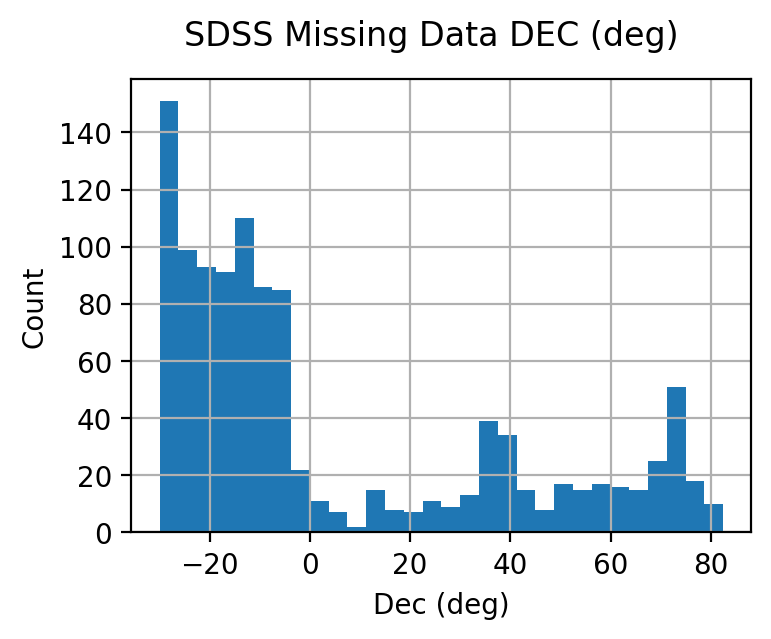

In [11]:
SDSSdata_nulls = HLdata[HLdata['SDSSobjID'].isnull()]

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

SDSSdata_nulls['DEC'].hist(bins=30, ax=ax)
ax.set_xlabel('Dec (deg)', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
fig.suptitle('SDSS Missing Data DEC (deg)', fontsize=12)

# fig.show()
fig.savefig('figures/SDSS_missing_dec.png', bbox_inches='tight')

Equation for calculation of Re is 

$R_e \approx \frac{R_{50}}{1 - P_3 (R_{90} / R_{50})^{P_4}} $

where P3 and P4 equal $8.0\times10^{-6}$ and $8.47$, respectively.

In [12]:
HLdata['Re_SDSS_g_calc']=HLdata['petroR50_g']/(1-(8.0E-6)*(HLdata['petroR90_g']/HLdata['petroR50_g'])**8.47)
HLdata['Re_SDSS_r_calc']=HLdata['petroR50_r']/(1-(8.0E-6)*(HLdata['petroR90_r']/HLdata['petroR50_r'])**8.47)

HLdata['Re_SDSS_g_calc'].where(HLdata['Re_SDSS_g_calc']>0, np.nan, inplace=True)
HLdata['Re_SDSS_r_calc'].where(HLdata['Re_SDSS_r_calc']>0, np.nan, inplace=True)

HLdata

,Name,RA,DEC,l,b,extinct,eff_B-V,t,type,v,...,petroR90_g,deVRad_g,expRad_g,petroMag_r,petroR50_r,petroR90_r,deVRad_r,expRad_r,Re_SDSS_g_calc,Re_SDSS_r_calc
0,NGC5236,204.253900,-29.865626,314.583657,31.972863,0.288,0.720,5.0,Sc,508.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NGC5457,210.802368,54.349023,102.037311,59.771285,0.037,0.585,5.9,SABc,236.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NGC5194,202.469547,47.195151,104.851473,68.560882,0.152,0.680,4.0,SABb,460.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NGC4258,184.739936,47.303882,138.319830,68.842281,0.071,0.805,4.0,Sbc,454.2,...,64.98389,29.66505,27.573780,9.952083,24.971750,64.47732,29.677070,26.597280,26.243724,25.603691
4,NGC4594,189.997701,-11.623010,298.460680,51.149343,0.221,1.025,1.1,Sa,1087.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,PGC021278,113.325917,32.546028,186.671819,22.432541,0.212,NaN,4.8,Sc,8032.0,...,15.76192,14.77722,8.834880,14.463420,6.215060,15.46181,11.975860,7.620049,6.899548,6.329081
3710,PGC2082878,206.475387,36.565902,75.597780,75.099876,0.053,NaN,-0.3,S0-a,7943.9,...,17.75195,7.38708,5.438406,14.313770,5.617527,17.18480,7.067024,5.425259,6.479335,6.268027
3711,UGC11901,331.342182,5.183812,65.424645,-38.495908,0.232,NaN,3.3,Sb,8108.7,...,18.94399,22.17456,11.140440,14.557850,6.904688,18.10885,19.119860,10.628960,7.447729,7.104873
3712,PGC020057,105.745999,18.538222,197.511316,10.805060,0.243,NaN,NaN,NaN,8190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
print(HLdata['appDiam_arcsec'].describe())
print(HLdata['Re_SDSS_g_calc'].describe())
print(HLdata['Re_SDSS_r_calc'].describe())


count    3656.000000
mean       85.771266
std        69.955020
min        12.651769
25%        54.469232
50%        69.207195
75%        93.143221
max      1439.299751
Name: appDiam_arcsec, dtype: float64
count    2596.000000
mean       10.814110
std         5.979657
min         0.691001
25%         7.379259
50%         9.857796
75%        12.928240
max       147.840731
Name: Re_SDSS_g_calc, dtype: float64
count    2602.000000
mean       10.494657
std         4.867794
min         0.075915
25%         7.290593
50%         9.681966
75%        12.544862
max        39.258333
Name: Re_SDSS_r_calc, dtype: float64


In [14]:
HLdata['Re_SDSS_g_calc_kpc'] = ((HLdata['dist_Mpc'] * (HLdata['Re_SDSS_g_calc'])) / 206.265)
HLdata['Re_SDSS_r_calc_kpc'] = ((HLdata['dist_Mpc'] * (HLdata['Re_SDSS_r_calc'])) / 206.265)

appDiam_SDSS_g_calcx10 = HLdata['Re_SDSS_g_calc_kpc']*10
appDiam_SDSS_r_calcx10 = HLdata['Re_SDSS_r_calc_kpc']*10


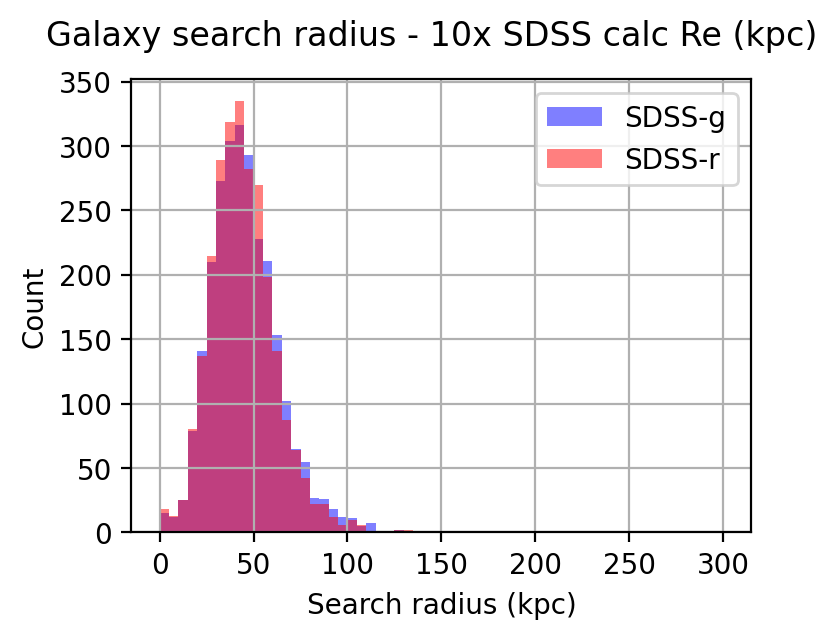

In [15]:
fig, ax = plt.subplots(figsize=(4,3), dpi=200)

appDiam_SDSS_g_calcx10.hist(bins=60, ax=ax, color='blue', label='SDSS-g', range=(0,300), alpha=0.5)
appDiam_SDSS_r_calcx10.hist(bins=60, ax=ax, color='red', label='SDSS-r', range=(0,300), alpha=0.5)

ax.set_xlabel('Search radius (kpc)', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
# ax.set_xlim(-10,330)
ax.legend()
fig.suptitle('Galaxy search radius - 10x SDSS calc Re (kpc)', fontsize=12)

fig.savefig('figures/Gal_search_rad_SDSS(10xRe).png', bbox_inches='tight')

In [16]:
from numpy.polynomial import polynomial as P

def bestfit(x, y, deg):
    c = P.polyfit(x, y, deg, rcond=None, full=False, w=None)
    return c

In [17]:
HLtemp2 = HLdata[['modbest','appDiam_arcsec','petroMag_g','petroMag_r','Re_SDSS_g_calc','Re_SDSS_r_calc']].dropna()
# linear = bestfit(HLdata['bt'], HLdata['vt'], 1)
# linear
# HLtemp2 = HLtemp.transpose().dropna()
HLtemp2['petroMag_G']=-(HLdata['modbest']-HLdata['petroMag_g'])
HLtemp2['petroMag_R']=-(HLdata['modbest']-HLdata['petroMag_r'])
HLtemp2 = HLtemp2[HLtemp2['petroMag_G']<-18.0]
HLtemp2 = HLtemp2[HLtemp2['petroMag_R']<-18.0]

HLtemp2['petroMag_R'].describe()


count    2548.000000
mean      -21.378711
std         0.544137
min       -23.376790
25%       -21.706812
50%       -21.376440
75%       -21.060102
max       -18.794830
Name: petroMag_R, dtype: float64

Text(0.5, 0.98, 'SDSS absolute Petrosian mag')

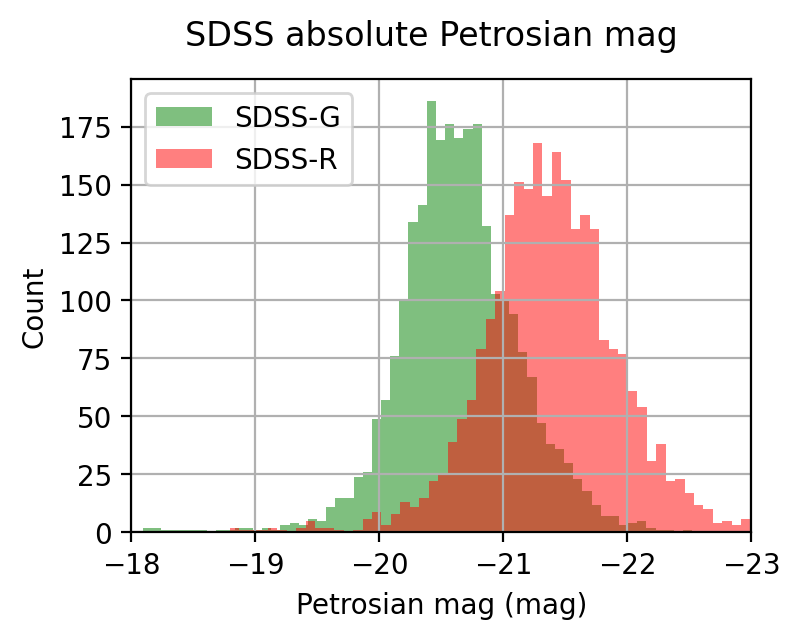

In [18]:
fig, ax = plt.subplots(figsize=(4,3), dpi=200)

HLtemp2['petroMag_G'].hist(bins=60, ax=ax, color='green', label='SDSS-G', alpha=0.5)
HLtemp2['petroMag_R'].hist(bins=60, ax=ax, color='red', label='SDSS-R', alpha=0.5)

ax.set_xlabel('Petrosian mag (mag)', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_xlim(-18,-23)
ax.legend()
fig.suptitle('SDSS absolute Petrosian mag', fontsize=12)

# fig.savefig('figures/SDSS_Abs_Petrosian_mag_dist.png', bbox_inches='tight')

In [19]:
c,m = bestfit(HLtemp2['appDiam_arcsec'], HLtemp2['Re_SDSS_g_calc']*2, 1)
c,m


(12.417150571333572, 0.11922910451057461)

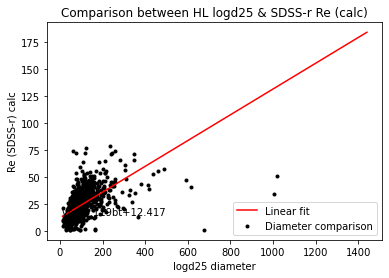

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xmin = np.min(HLdata['appDiam_arcsec'])
xmax = np.max(HLdata['appDiam_arcsec'])
x = np.linspace(xmin-1,xmax+1,100)
y = m*x + c

plt.scatter(HLdata['appDiam_arcsec'], HLdata['Re_SDSS_r_calc']*2, label='Diameter comparison', marker='.', c='black')
plt.plot(x, y, '-r', label=f'Linear fit')

plt.legend(loc='lower right')
plt.xlabel('logd25 diameter')
plt.ylabel('Re (SDSS-r) calc')
plt.title('Comparison between HL logd25 & SDSS-r Re (calc)')
plt.text(7, 15, f'vt={m:6.3f}bt{c:+5.3f}')
plt.show()

### Investigate size (Re) vs. Luminosity
First plot for all galaxies, then repeat for grouping on galaxy type

Type could be based on HL 'type' parameter (str) which is Hubble type, but probably easier to use 't', which is de Vaucouleurs morphological definition (float)

In [21]:
# HLtemp3 = pd.DataFrame([HLdata['t'], 
#                         HLdata['appDiam_kpc'], 
#                         np.log10(HLdata['Re_SDSS_g_calc_kpc']), 
#                         np.log10(HLdata['Re_SDSS_r_calc_kpc']), 
#                         HLdata['Bmagt']])
HLtemp4 = HLdata[['t','modbest','appDiam_kpc','petroMag_g','petroMag_r','Re_SDSS_g_calc_kpc','Re_SDSS_r_calc_kpc','Bmagt']].dropna()

HLtemp4['log_Re_g_kpc']=np.log10(HLtemp4['Re_SDSS_g_calc_kpc'])
HLtemp4['log_Re_r_kpc']=np.log10(HLtemp4['Re_SDSS_r_calc_kpc'])

HLtemp4['petroMag_G']=-(HLdata['modbest']-HLdata['petroMag_g'])
HLtemp4['petroMag_R']=-(HLdata['modbest']-HLdata['petroMag_r'])
HLtemp4 = HLtemp4[HLtemp4['petroMag_G']<-18.0]
HLtemp4 = HLtemp4[HLtemp4['petroMag_R']<-18.0]


In [22]:
HLdata

,Name,RA,DEC,l,b,extinct,eff_B-V,t,type,v,...,expRad_g,petroMag_r,petroR50_r,petroR90_r,deVRad_r,expRad_r,Re_SDSS_g_calc,Re_SDSS_r_calc,Re_SDSS_g_calc_kpc,Re_SDSS_r_calc_kpc
0,NGC5236,204.253900,-29.865626,314.583657,31.972863,0.288,0.720,5.0,Sc,508.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NGC5457,210.802368,54.349023,102.037311,59.771285,0.037,0.585,5.9,SABc,236.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NGC5194,202.469547,47.195151,104.851473,68.560882,0.152,0.680,4.0,SABb,460.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NGC4258,184.739936,47.303882,138.319830,68.842281,0.071,0.805,4.0,Sbc,454.2,...,27.573780,9.952083,24.971750,64.47732,29.677070,26.597280,26.243724,25.603691,0.967832,0.944228
4,NGC4594,189.997701,-11.623010,298.460680,51.149343,0.221,1.025,1.1,Sa,1087.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,PGC021278,113.325917,32.546028,186.671819,22.432541,0.212,NaN,4.8,Sc,8032.0,...,8.834880,14.463420,6.215060,15.46181,11.975860,7.620049,6.899548,6.329081,3.940895,3.615055
3710,PGC2082878,206.475387,36.565902,75.597780,75.099876,0.053,NaN,-0.3,S0-a,7943.9,...,5.438406,14.313770,5.617527,17.18480,7.067024,5.425259,6.479335,6.268027,3.759281,3.636681
3711,UGC11901,331.342182,5.183812,65.424645,-38.495908,0.232,NaN,3.3,Sb,8108.7,...,11.140440,14.557850,6.904688,18.10885,19.119860,10.628960,7.447729,7.104873,4.321138,4.122215
3712,PGC020057,105.745999,18.538222,197.511316,10.805060,0.243,NaN,NaN,NaN,8190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
detail_colors = ["darkred","darkred","darkred","darkorange", "darkorange", "darkorange", 
                       "gold", "lawngreen", "lightseagreen","lightblue","blue","darkblue","darkblue","darkblue",
                       "violet","darkviolet","darkviolet"]
cmap_detail = [ListedColormap(detail_colors),'detail', detail_colors]

rough_colors = ["darkred","darkred","darkred",
                             "darkorange", "darkorange", "darkorange", 
                             "gold", 
                             "darkblue", 
                             "darkblue",
                             "darkblue",
                             "darkblue",
                             "darkblue","darkblue","darkblue",
                             "darkviolet",
                             "darkviolet","darkviolet"]
rough_colors2 = ["darkred","darkred","darkred",
                             "darkred","darkred","darkred",
                             "darkred", 
                             "darkblue", 
                             "darkblue",
                             "darkblue",
                             "darkblue",
                             "darkblue","darkblue","darkblue",
                             "darkorange",
                             "darkorange","darkorange"]
cmap_rough = [ListedColormap(rough_colors2), 'rough', rough_colors2]

min_colors = ["darkred", "darkblue","darkorange"]
cmap_min = [ListedColormap(min_colors), 'min', min_colors]

Re_g_series = ['log_Re_g_kpc','g','petroMag_G']
Re_r_series = ['log_Re_r_kpc','r','petroMag_R']


In [24]:
# segments=[-6,-4,-1,0,1,2,3,4,5,7,8,9,11]
def segment_lines(HLtempSL, x_col, y_col, f_str, segments=[-6,0,7,11]):

    seg_arr=[]
    for i,j in enumerate(segments):
        if i==len(segments)-1:
            break
        HLsegment = HLtempSL[(HLtempSL['t']>=segments[i]) & (HLtempSL['t']<segments[i+1])]
        print(f'Length of segment {i} is {len(HLsegment)}')

        c = bestfit(HLsegment[x_col], HLsegment[y_col], 1)
        seg_arr.append({'idx': i, 'range': {'left': segments[i], 'right': segments[i+1]}, 
                        'filter': f_str, 'coeff': {'c': c[0], 'm1': c[1]}, 'data': HLsegment })

    return seg_arr

def plot_segments(seg_arr, ax, cmap1=min_colors):
    
    for i, seg in enumerate(seg_arr):
        print(cmap1[i])
        xmin = np.min(seg['data'][Re_series[2]])
        xmax = np.max(seg['data'][Re_series[2]])
        x = np.linspace(xmin,xmax,100)
        y = seg['coeff']['m1']*x + seg['coeff']['c']
        if i in [0,1,2]:
            ax.plot(x, y, seg['filter'], color=cmap1[i])

def addReCalcBmagCol(seg_arr, HL_DF, segments=[-6,0,7,11]):
    for i,j in enumerate(segments):
        if i==len(segments)-1:
            break

        m = seg_arr[i]['coeff']['m1']
        c = seg_arr[i]['coeff']['c']
        HLdata.loc[((HL_DF['t']>=segments[i]) & 
                          (HL_DF['t']<segments[i+1])),'Re_BmagCalc_kpc'] = np.power(10, m * HL_DF['Bmagt'] + c)

    HLdata.loc[np.isnan(HL_DF['t']),'Re_BmagCalc_kpc'] = np.power(10, seg_arr[1]['coeff']['m1'] * HL_DF['Bmagt'] + seg_arr[1]['coeff']['c'])
    HLdata['Re_BmagCalc_arcsec'] = (206.265 * HLdata['Re_BmagCalc_kpc'])/HLdata['dist_Mpc']

    

Length of segment 0 is 889
Length of segment 1 is 1641
darkred
darkblue


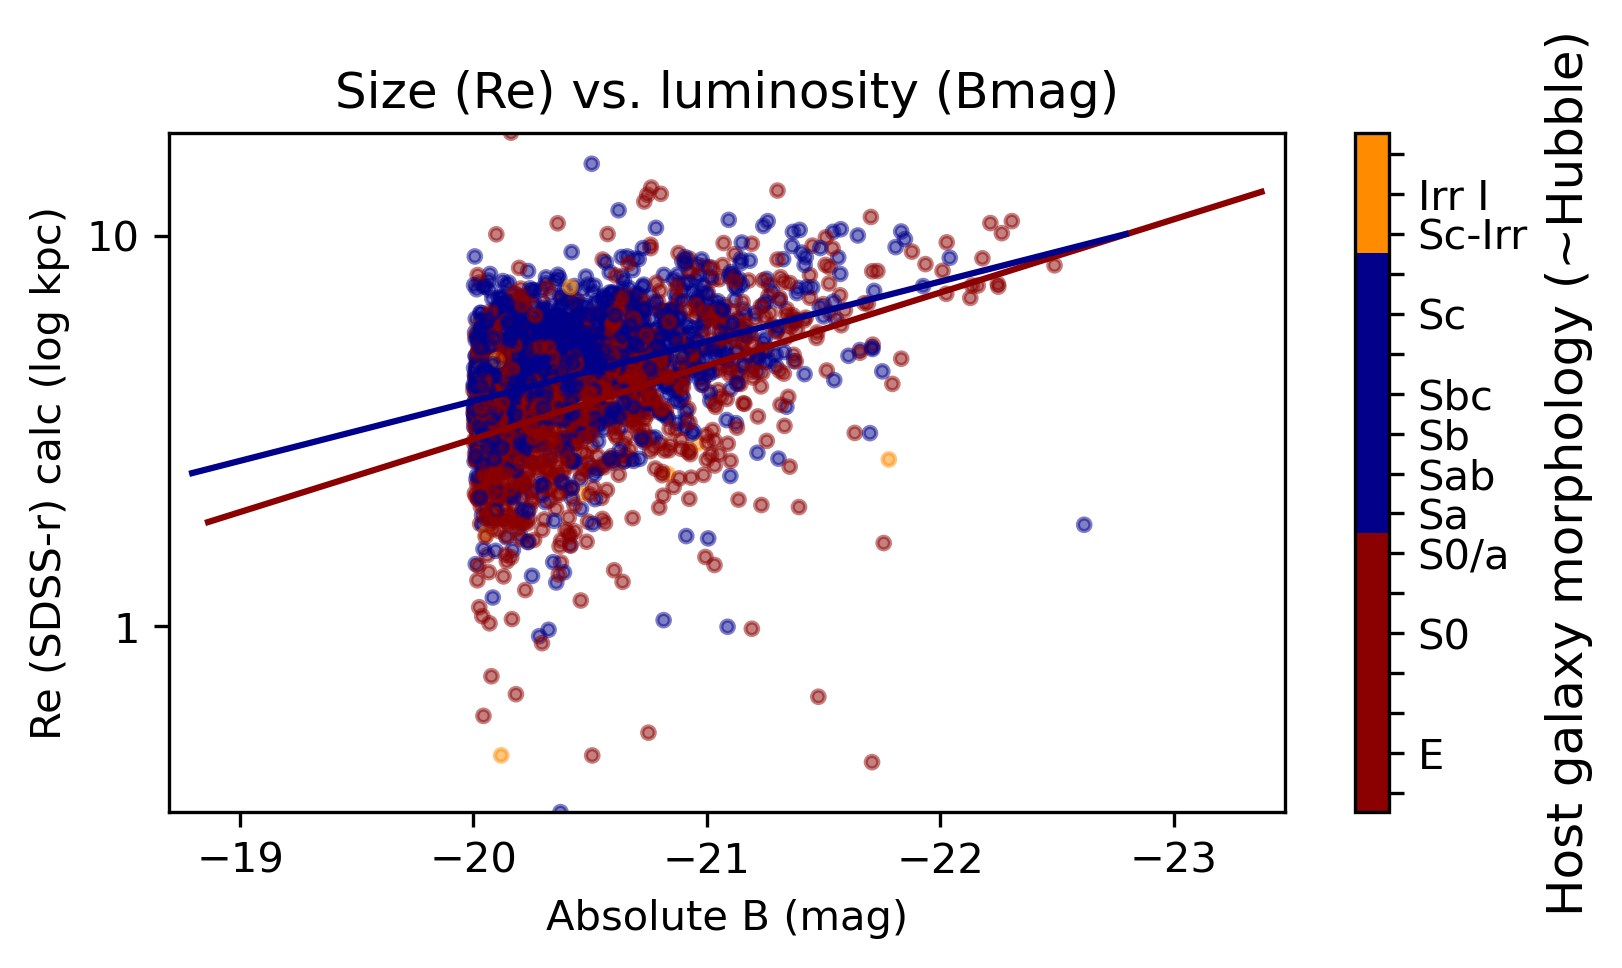

In [36]:
# HLtemp4['t'], HLtemp4['Re_SDSS_calc'], HLtemp4['Bmagt']

fig = plt.figure(figsize=(6,3), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# select colour resolution and series to plot
cmap=cmap_rough
Re_series = Re_r_series

# xmin = np.min(HLdata['appDiam_arcsec'])
ax.set_ylim(0, np.max(HLtemp4[Re_series[0]])+.1)
ax.set_ylim(np.min(HLtemp4[Re_series[0]]), np.max(HLtemp4[Re_series[0]]))

ax.set_xlim(np.max(HLtemp4['Bmagt'])+.1, np.min(HLtemp4['Bmagt'])-.1)
ax.set_xlim(np.max(HLtemp4[Re_series[2]])+.1, np.min(HLtemp4[Re_series[2]])-.1)

# x = np.linspace(xmin-1,xmax+1,100)
# y = m*x + c

ax.scatter(HLtemp4['Bmagt'], HLtemp4[Re_series[0]], label='Size', marker='.', 
            c=HLtemp4['t'], cmap=cmap[0], alpha=0.5)
# plt.scatter(HLtemp4['appDiam_kpc'], HLtemp4['Bmagt'], label='Size', marker='.', c='red')

# plt.plot(x, y, '-r', label=f'Linear fit')

# plt.legend(loc='upper right')
ax.set_xlabel('Absolute B (mag)')
ax.set_yticks([0.00,1.00])
ax.set_yticklabels(['1','10'])
ax.set_ylabel(f'Re (SDSS-{Re_series[1]}) calc (log kpc)')
ax.set_title('Size (Re) vs. luminosity (Bmag)')
# plt.text(7, 15, f'vt={m:6.3f}bt{c:+5.3f}')

norm = colors.Normalize(vmin=-7,vmax=11)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap[0]), ax=ax)
cbar.set_label(label='Host galaxy morphology (~Hubble)', size='large')
cbar.set_ticks(np.linspace(-6.5,11.5,18))
cbar.set_ticklabels(['','E','','','S0','','S0/a','Sa','Sab','Sb','Sbc','','Sc','','Sc-Irr','Irr I'])
# cbar.ax.invert_yaxis()

seg_arr1 = segment_lines(HLtemp4, 'Bmagt', Re_series[0], Re_series[1], [-6,0,11])
plot_segments(seg_arr1, ax)

# plt.show()
fig.savefig(f'figures/Gal_sizeVsLum_wtype_{Re_series[1]}_{cmap[1]}.png', bbox_inches='tight')
# fig.savefig('figures/Gal_sizeVsLum_wtype.png', bbox_inches='tight')

addReCalcBmagCol(seg_arr1, HLdata, [-6,0,11])


In [26]:
addReCalcBmagCol(seg_arr1, HLdata, [-6,0,11])

print(HLdata['appDiam_kpc'].describe())
print(HLdata['Re_BmagCalc_kpc'].describe())
print()
print(HLdata['appDiam_arcsec'].describe())
print(HLdata['Re_BmagCalc_arcsec'].describe())

count    3656.000000
mean       32.158217
std        10.316905
min         2.892851
25%        25.242098
50%        30.579171
75%        37.477958
max       104.646683
Name: appDiam_kpc, dtype: float64
count    3714.000000
mean        4.266456
std         0.777518
min         3.021006
25%         3.823645
50%         4.137352
75%         4.620860
max         9.478761
Name: Re_BmagCalc_kpc, dtype: float64

count    3656.000000
mean       85.771266
std        69.955020
min        12.651769
25%        54.469232
50%        69.207195
75%        93.143221
max      1439.299751
Name: appDiam_arcsec, dtype: float64
count    3714.000000
mean       11.583124
std         9.541779
min         5.279187
25%         7.650132
50%         9.055134
75%        11.811062
max       198.548120
Name: Re_BmagCalc_arcsec, dtype: float64


In [27]:
HLdata.head()

,Name,RA,DEC,l,b,extinct,eff_B-V,t,type,v,...,petroR50_r,petroR90_r,deVRad_r,expRad_r,Re_SDSS_g_calc,Re_SDSS_r_calc,Re_SDSS_g_calc_kpc,Re_SDSS_r_calc_kpc,Re_BmagCalc_kpc,Re_BmagCalc_arcsec
0,NGC5236,204.253900,-29.865626,314.583657,31.972863,0.288,0.720,5.0,Sc,508.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.714552,198.548120
1,NGC5457,210.802368,54.349023,102.037311,59.771285,0.037,0.585,5.9,SABc,236.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.177333,150.152165
2,NGC5194,202.469547,47.195151,104.851473,68.560882,0.152,0.680,4.0,SABb,460.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.477302,131.701966
3,NGC4258,184.739936,47.303882,138.319830,68.842281,0.071,0.805,4.0,Sbc,454.2,...,24.97175,64.47732,29.67707,26.59728,26.243724,25.603691,0.967832,0.944228,4.166583,112.981025
4,NGC4594,189.997701,-11.623010,298.460680,51.149343,0.221,1.025,1.1,Sa,1087.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.529103,108.601970


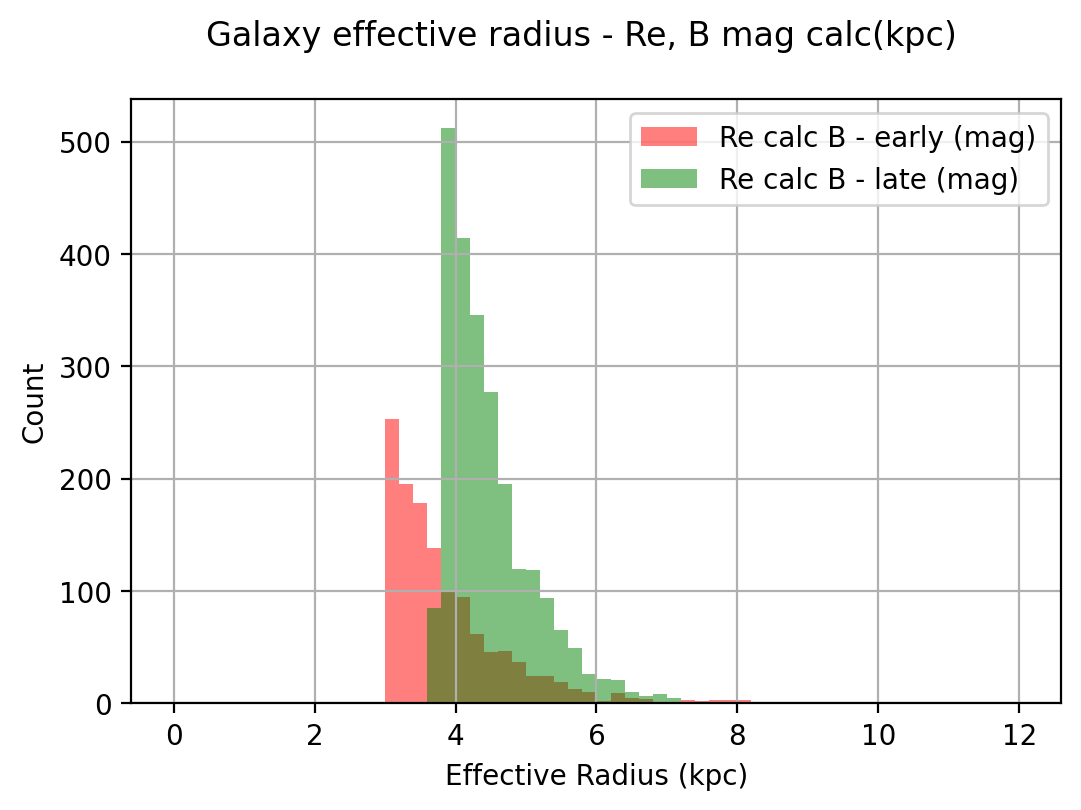

In [28]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)

HLdata.loc[((HLdata['t']>=-6) & (HLdata['t']<0)),'Re_BmagCalc_kpc'].hist(bins=60, 
                                                                         ax=ax, 
                                                                         color='red', 
                                                                         label='Re calc B - early (mag)', 
                                                                         range=(0,12), 
                                                                         alpha=0.5)
HLdata.loc[((HLdata['t']>=0) & (HLdata['t']<11)),'Re_BmagCalc_kpc'].hist(bins=60, 
                                                                         ax=ax, 
                                                                         color='green', 
                                                                         label='Re calc B - late (mag)', 
                                                                         range=(0,12), 
                                                                         alpha=0.5)
ax.set_xlabel('Effective Radius (kpc)', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
# ax.set_xlim(-10,330)
ax.legend()
fig.suptitle('Galaxy effective radius - Re, B mag calc(kpc)', fontsize=12)

fig.savefig('figures/Gal_Re_Bmag_calc.png', bbox_inches='tight')


In [29]:
HLtemp4['appDiam_kpc'].describe()

count    2530.000000
mean       31.884554
std        10.185689
min         2.892851
25%        25.103000
50%        30.382666
75%        37.006312
max       104.646683
Name: appDiam_kpc, dtype: float64

In [30]:
np.power(10,HLtemp4['log_Re_r_kpc']).describe()

count    2530.000000
mean        4.524710
std         1.735707
min         0.334950
25%         3.347606
50%         4.349077
75%         5.466176
max        18.337977
Name: log_Re_r_kpc, dtype: float64

Length of segment 0 is 889
Length of segment 1 is 1604
Length of segment 2 is 37
darkred
darkblue
darkorange


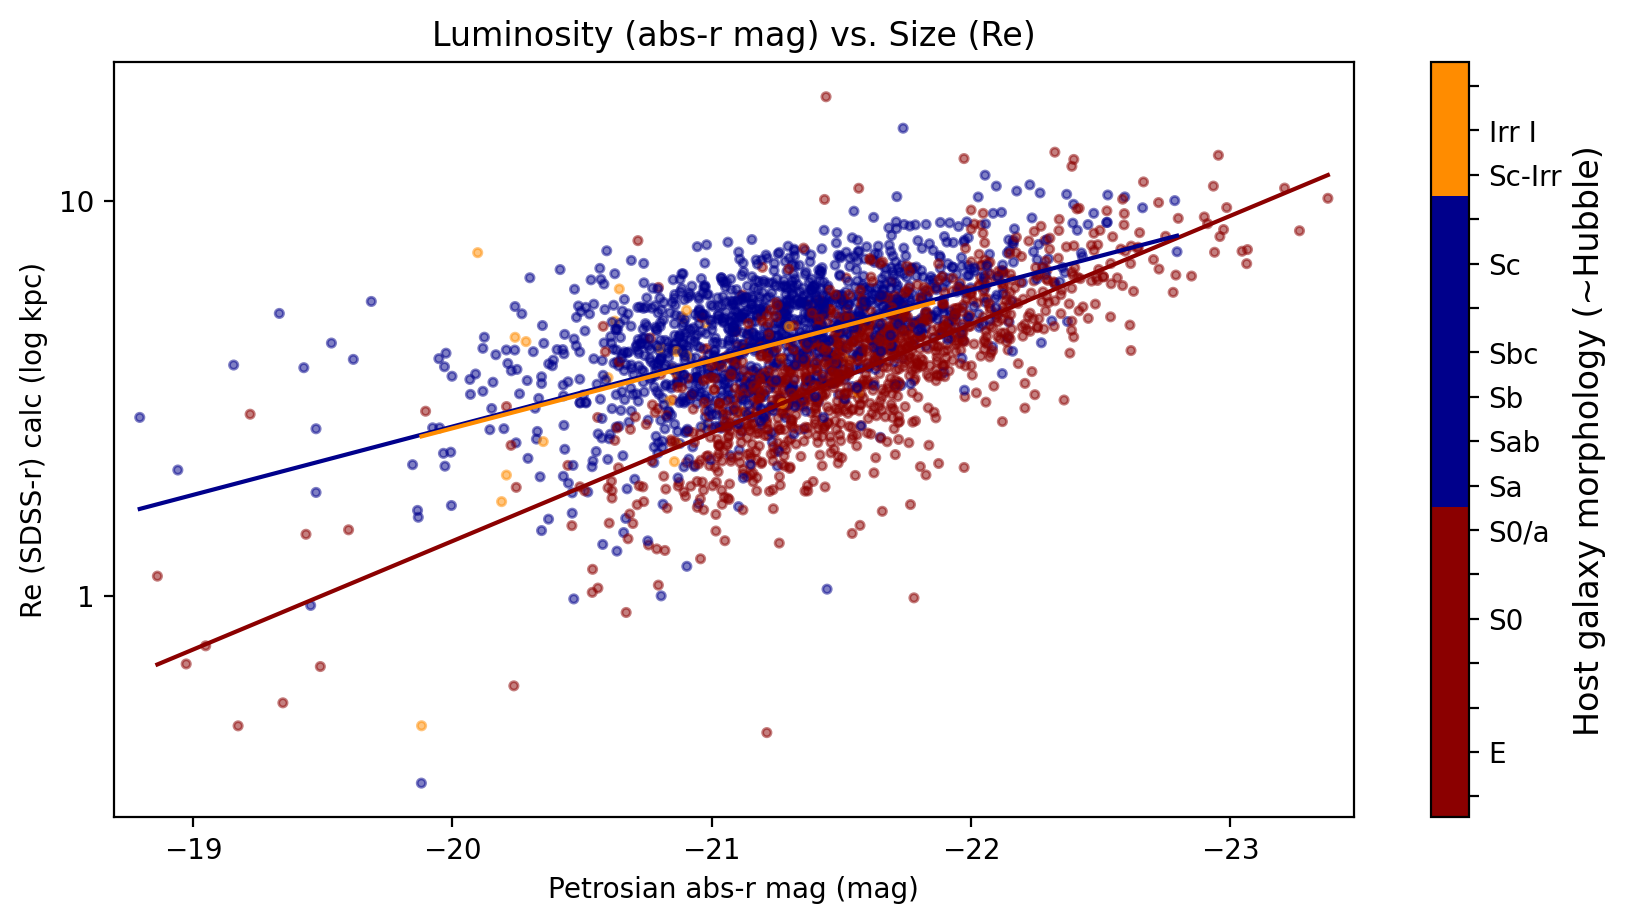

In [31]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = fig.add_subplot(1, 1, 1)

# select colour resolution and series to plot
cmap=cmap_rough
Re_series = Re_r_series

# xmin = np.min(HLdata['appDiam_arcsec'])
# ax.set_ylim(0, np.max(HLtemp4[Re_series[0]])+.1)
ax.set_xlim(np.max(HLtemp4[Re_series[2]])+.1, np.min(HLtemp4[Re_series[2]])-.1)

ax.scatter(HLtemp4[Re_series[2]], HLtemp4[Re_series[0]], label='Size', marker='.', 
            c=HLtemp4['t'], cmap=cmap[0], alpha=0.5)

ax.set_xlabel(f'Petrosian abs-{Re_series[1]} mag (mag)')
ax.set_ylabel(f'Re (SDSS-{Re_series[1]}) calc (log kpc)')
ax.set_yticks([0.00,1.00])
ax.set_yticklabels(['1','10'])
ax.set_title(f'Luminosity (abs-{Re_series[1]} mag) vs. Size (Re)')

norm = colors.Normalize(vmin=-7,vmax=11)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap[0]), ax=ax)
cbar.set_label(label='Host galaxy morphology (~Hubble)', size='large')
cbar.set_ticks(np.linspace(-6.5,11.5,18))
cbar.set_ticklabels(['','E','','','S0','','S0/a','Sa','Sab','Sb','Sbc','','Sc','','Sc-Irr','Irr I'])
# cbar.ax.invert_yaxis()

seg_arr = segment_lines(HLtemp4, Re_series[2], Re_series[0], Re_series[1])
plot_segments(seg_arr, ax)

fig.savefig(f'figures/Gal_sizeVsRmag_wtype_{Re_series[1]}_{cmap[1]}.png', bbox_inches='tight')




Length of segment 0 is 889
Length of segment 1 is 1641
darkred
darkblue


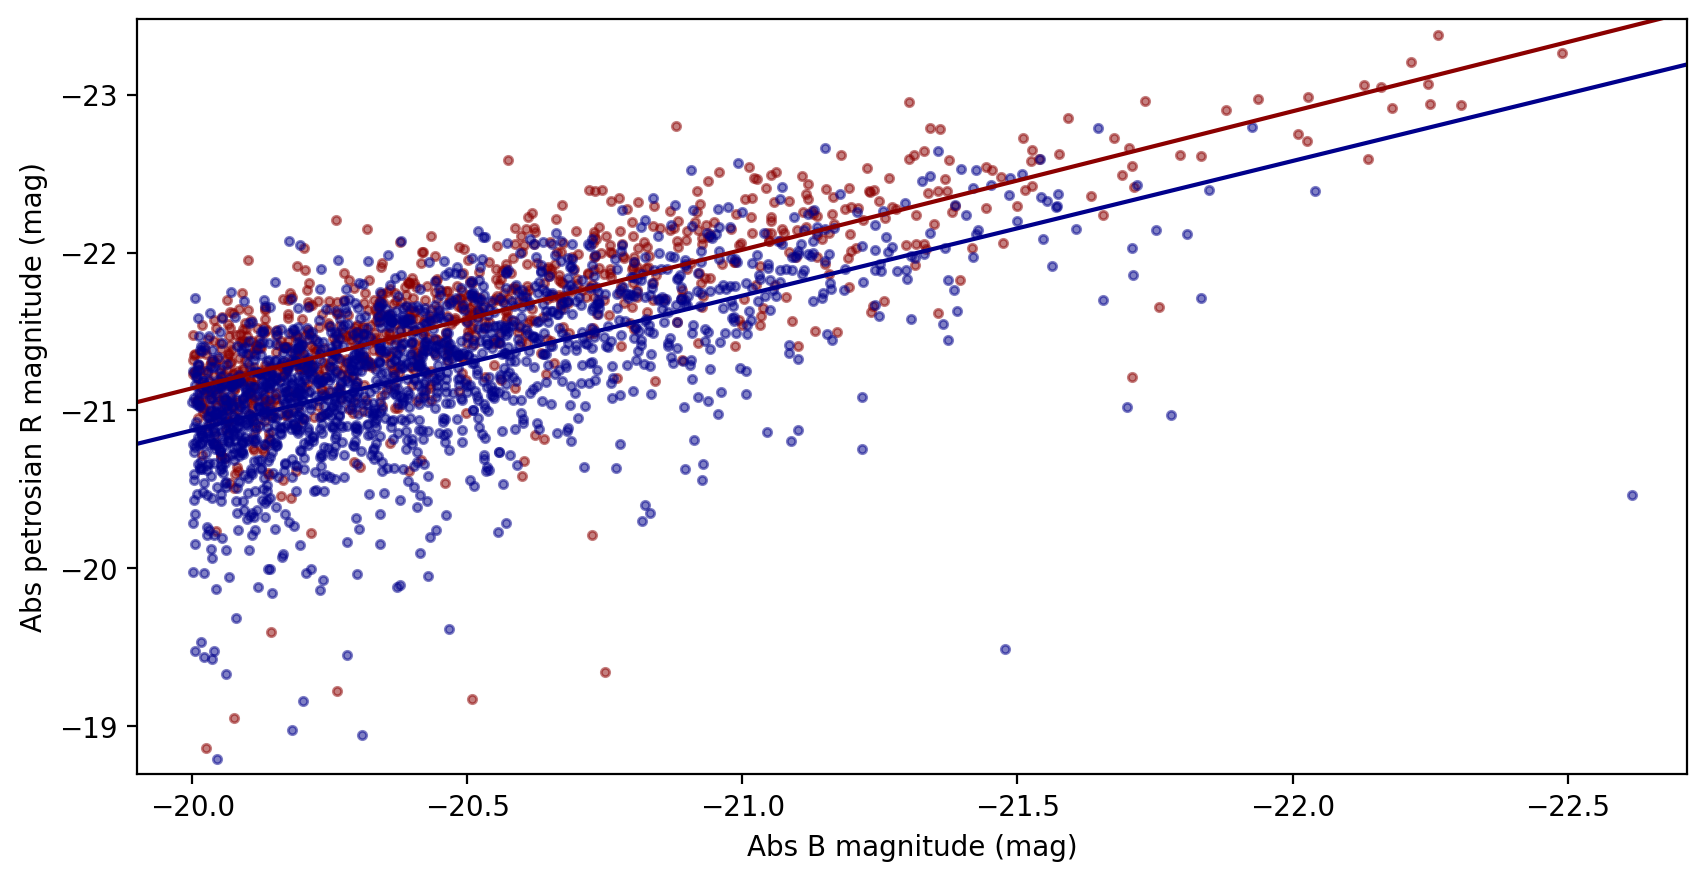

In [32]:
c_early = bestfit(HLtemp4[HLtemp4['t']<=0]['Bmagt'], HLtemp4[HLtemp4['t']<=0]['petroMag_R'], 1)
c_late = bestfit(HLtemp4[HLtemp4['t']>0]['Bmagt'], HLtemp4[HLtemp4['t']>0]['petroMag_R'], 1)

fig = plt.figure(figsize=(10,5), dpi=200)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(HLtemp4[HLtemp4['t']<=0]['Bmagt'], HLtemp4[HLtemp4['t']<=0]['petroMag_R'],c='darkred',alpha=0.5,marker='.')
ax.scatter(HLtemp4[HLtemp4['t']>0]['Bmagt'], HLtemp4[HLtemp4['t']>0]['petroMag_R'],c='darkblue',alpha=0.5,marker='.')

ax.set_xlim(np.max(HLtemp4['Bmagt'])+.1, np.min(HLtemp4['Bmagt'])-.1)
ax.set_ylim(np.max(HLtemp4['petroMag_R'])+.1, np.min(HLtemp4['petroMag_R'])-.1)
ax.set_xlabel('Abs B magnitude (mag)')
ax.set_ylabel('Abs petrosian R magnitude (mag)')

# xmin = np.min(seg['data'][Re_series[2]])
# xmax = np.max(seg['data'][Re_series[2]])
# x = np.linspace(xmin,xmax,100)
# y = seg['coeff']['m1']*x + seg['coeff']['c']

# ax.plot(x, y, seg['filter'], label=f'Quad fit', color=cmap1[i])

seg_arr = segment_lines(HLtemp4, 'Bmagt', 'petroMag_R', Re_series[1], [-6,0,11])
plot_segments(seg_arr, ax)

In [33]:
HLdata.to_csv('data/HLGalaxies_filtered_wReBmag.csv', index=False)

In [34]:
HLdata.columns

Index(['Name', 'RA', 'DEC', 'l', 'b', 'extinct', 'eff_B-V', 't', 'type', 'v',
       'e_v', 'dist_Hf', 'bt', 'e_bt', 'Bmagt', 'it', 'e_it', 'ut', 'vt',
       'modbest', 'e_modbest', 'dist_Mpc', 'logd25', 'hl_names(pgc)',
       'appDiam_arcsec', 'appDiam_kpc', 'est_vt', 'est_Vmagt', 'Sn', 'Ngc',
       'sigma_G', 'mu_g', 'vis_GCs', 'pc_vis_GCs', 'SDSSobjID', 'SDSSnChild',
       'SDSSra', 'SDSSdec', 'SDSSdistance', 'petroMag_g', 'petroR50_g',
       'petroR90_g', 'deVRad_g', 'expRad_g', 'petroMag_r', 'petroR50_r',
       'petroR90_r', 'deVRad_r', 'expRad_r', 'Re_SDSS_g_calc',
       'Re_SDSS_r_calc', 'Re_SDSS_g_calc_kpc', 'Re_SDSS_r_calc_kpc',
       'Re_BmagCalc_kpc', 'Re_BmagCalc_arcsec'],
      dtype='object')